In [ ]:
!pip install rasterio==1.2.10
!pip install xarray-spatial==0.3.4
!pip install rtxpy
!pip install numba==0.55.1
!pip install geopandas
!pip install spatialpandas

# Mountain peak with best view

In this notebook, we want to identify the mountain with best view in Colorado, USA. The elevation raster used in this notebook is from the SRTM dataset. Mountain peaks data is extracted from Open Street Map. We'll use `viewshed` tool from `xarray-spatial` to calculate the visibility grids from top 20 highest peaks in Colorado and choose the peak where the most places can be seen. 

### Imports

First, let's import all necessary packages to run the notebook.

In [1]:
import xarray as xr
import numpy as np
import cupy

import geopandas as gpd
import spatialpandas as spd

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

from xrspatial import viewshed
from xrspatial.utils import canvas_like


### Load data

The input raster data covers the state of Colorado, USA. We'll load it from a input file and calculate its bounding box.

In [2]:
file_name = 'colorado_merge_3arc_resamp.tif'
raster = xr.open_rasterio(file_name).sel(band=1)

xmin, xmax = raster.x.data.min(), raster.x.data.max()
ymin, ymax = raster.y.data.min(), raster.y.data.max()

xmin, xmax, ymin, ymax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  


(-109.99974993088883,
 -102.00025006911117,
 36.000333437166745,
 41.999666562833255)

Now we'll load the mountain peaks data into a Data Frame. The data includes all the country of USA. We'll use the bounding box calculated above to select the peaks within the study area.

In [3]:
us_peaks_df = gpd.read_file('peaks_data/us_peaks.shp')

# select peaks within raster bounds
peaks_df = us_peaks_df.cx[xmin:xmax, ymin:ymax]

As a simple heuristic, higher mountains may have better visibility, we'll select top 20 highest peaks to compute their visibility.

In [4]:

# select top 20 highest peaks
n_peaks = 20
peaks_df = peaks_df.dropna(subset=['ELEV_METER']).sort_values(by=['ELEV_METER'], ascending=[False])
top_peaks = peaks_df.head(n_peaks)
top_peaks

,OBJECTID,NAME,STCTYFIPS,ELEV_METER,geometry
6485,6486.0,Mount Elbert,08065,4397.0,POINT (-106.44526 39.11787)
68983,68984.0,Gannett Peak (Not Official),08065,4393.0,POINT (-106.47558 39.18753)
6431,6432.0,Mount Massive,08065,4393.0,POINT (-106.47558 39.18753)
7454,7455.0,Mount Harvard,08015,4391.0,POINT (-106.32058 38.92444)
7906,7907.0,Blanca Peak,08023,4373.0,POINT (-105.48560 37.57756)
6487,6488.0,La Plata Peak,08015,4369.0,POINT (-106.47311 39.02936)
7869,7870.0,Crestone Peak,08109,4360.0,POINT (-105.58539 37.96681)
7377,7378.0,Uncompahgre Peak,08053,4359.0,POINT (-107.46200 38.07166)
8526,8527.0,Crestone Peaks,08109,4354.0,POINT (-105.58535 37.96684)
6412,6413.0,Mount Lincoln,08093,4354.0,POINT (-106.11138 39.35150)


#### Visualize input data

To have a quick overview of the data, we'll downsample the raster with a lower resolution then visualize it with `datashader`

In [5]:
# Create a datashader Canvas to visualize input raster and input mountain peaks

small_w = 400
small_raster = canvas_like(raster, width=small_w)
small_image_raster = shade(small_raster, cmap=Elevation, alpha=255)
small_image_raster = set_background(small_image_raster, "black")

Create a point image of select mountain peaks.

In [6]:
cvs = ds.Canvas(
    plot_height=small_raster.shape[0],
    plot_width=small_raster.shape[1],
    x_range=(xmin, xmax),
    y_range=(ymin, ymax)
)

peaks_sdf = spd.GeoDataFrame(top_peaks, geometry="geometry")
small_peaks_raster = cvs.points(peaks_sdf, geometry='geometry')
small_image_peaks = dynspread(shade(small_peaks_raster, cmap=['red'], alpha=255), threshold=1, max_px=3)

/usr/local/lib/python3.7/dist-packages/spatialpandas/geometry/point.py:31: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  return np.asarray(shape.ctypes)


Combine raster and point data into a single image. Mountain peaks are marked as red points.

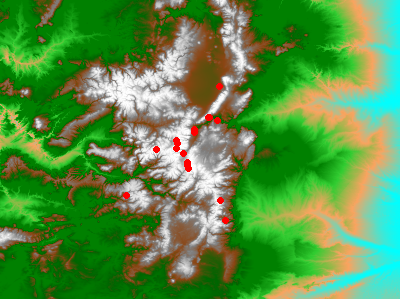

In [7]:
stack(small_image_raster, small_image_peaks)

### Calculate visibility

We'll transfer the raster data to the GPU. For each selected point in top 20 highest peaks, we'll calculate their visibility with `xrspatial.viewshed` and compute the areas that can be seen from that point. Mountain peak with largest visibility area is the mountain with best view.

In [8]:
raster.data = cupy.asarray(raster.data)
raster

<xarray.DataArray (y: 4000, x: 6000)>
array([[1957., 1956., 1955., ..., 1175., 1174., 1174.],
       [1958., 1957., 1957., ..., 1178., 1177., 1178.],
       [1957., 1954., 1953., ..., 1195., 1192., 1187.],
       ...,
       [2046., 2031., 2020., ..., 1109., 1109., 1107.],
       [2028., 2024., 2019., ..., 1112., 1112., 1107.],
       [2003., 2005., 2006., ..., 1109., 1110., 1108.]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 42.0 42.0 42.0 42.0 41.99 ... 36.01 36.0 36.0 36.0 36.0
  * x        (x) float64 -110.0 -110.0 -110.0 -110.0 ... -102.0 -102.0 -102.0
Attributes:
    transform:      (0.0013334722223333321, 0.0, -110.000416667, 0.0, -0.0015...
    crs:            +init=epsg:4326
    res:            (0.0013334722223333321, 0.0015002083335000015)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [9]:
# invisible points from a view point are marked as -1 in the output visibility grid
INVISIBLE = -1

visibility_grids = []
visibility_areas = []

for i, peak in top_peaks.iterrows():
    viewpoint_x, viewpoint_y = peak['geometry'].x, peak['geometry'].y
    viewpoint_elev = peak['ELEV_METER']    
    visibility_grid = viewshed(raster, x=viewpoint_x, y=viewpoint_y)
    visibility_area = len(cupy.where(visibility_grid.data != -1)[0])
    visibility_areas.append(visibility_area)
    visibility_grids.append(visibility_grid)

Find the location with best view.

In [10]:
best_peak_id = visibility_areas.index(max(visibility_areas))

top_peaks.iloc[best_peak_id]

OBJECTID                                             6486.0
NAME                                           Mount Elbert
STCTYFIPS                                             08065
ELEV_METER                                           4397.0
geometry      POINT (-106.44525689999995 39.11786870000003)
Name: 6485, dtype: object

Visualize the output result.

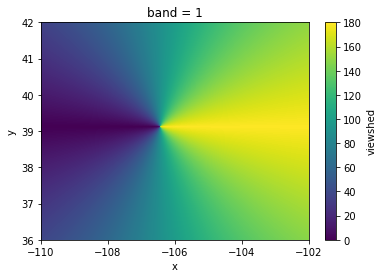

In [11]:
visibility_grids[best_peak_id].plot.imshow()